**Sétimo Trabalho**

**Nome: Valéria Cristina A. R. de Figueredo**

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# https://drive.google.com/file/d/1pV7MIW_r3DExQzMNdkcCMZZr_Ww69Ykz/view?usp=sharing

# Baixa e extrai o dataset
!curl -L -o data/bloom_dataset_ptbr.csv "https://drive.google.com/uc?export=download&id=1pV7MIW_r3DExQzMNdkcCMZZr_Ww69Ykz"
!unzip data/bloom_dataset_ptbr.csv -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3262k  100 3262k    0     0  1026k      0  0:00:03  0:00:03 --:--:-- 1146k
Archive:  data/bloom_dataset_ptbr.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data/bloom_dataset_ptbr.csv or
        data/bloom_dataset_ptbr.csv.zip, and cannot find data/bloom_dataset_ptbr.csv.ZIP, period.


In [7]:
df = pd.read_csv('data/bloom_dataset_ptbr.csv')

df.fillna(0, inplace=True)
df['one_hot'] = list(df.iloc[:, 1:-1].values)

LABELS = list(df.iloc[:, 1:-1])
print(LABELS)

df.head()

['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']


,text,remember,understand,apply,analyze,evaluate,create,one_hot
0,Analisar as implicações econômicas para a saúd...,0.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,Aplicar competências de investigação para func...,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,Avaliação e síntese de diversas informações so...,0.0,0.0,0.0,0.0,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
3,Descreva as características gerais do moderno ...,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,Avaliação dos diferentes modelos de cuidados p...,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [8]:
class BloomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        text, one_hot = df.loc[index, ['text', 'one_hot']]
        target = np.argmax(one_hot)
        target = torch.tensor(one_hot).float()
        return text, target

    def __len__(self):
        return len(self.df)

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)

train_set = BloomDataset(df_train)
test_set = BloomDataset(df_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [10]:
train_set[0]

('Analisar as implicações econômicas para a saúde da prática perioperativa eficiente.',
 tensor([0., 0., 0., 1., 0., 0.]))

In [11]:
# Load the model and tokenizer

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(LABELS))
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Access the last encoder layer
last_encoder_layer = model.bert.encoder.layer[-1]

print(last_encoder_layer)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [12]:
class BloomClassifier(nn.Module):
    def __init__(
        self,
        num_classes=6,
        bert_model='neuralmind/bert-base-portuguese-cased',
        freeze_bert=True,
        labels=LABELS
    ):
        super().__init__()
        self.num_classes = num_classes
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
        self.bert = AutoModel.from_pretrained(bert_model)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.labels = labels

        if freeze_bert:
            # Congelando todas as camadas...
            for param in self.bert.parameters():
                    param.requires_grad = False

            # ... menos as duas últimas
            for param in self.bert.encoder.layer[-2:].parameters():
                param.requires_grad = True

    def forward(self, **kwargs):
        encodings = self.bert(**kwargs).last_hidden_state
        encodings = encodings[:, 0, :]
        outputs = self.fc(encodings)
        outputs = torch.sigmoid(outputs)
        return outputs

    def predict(self, text, return_labels=True, threshold=0.5):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True).to(self.encoder.device)
        outputs = (self.forward(**inputs) > threshold).int().squeeze()

        if return_labels:
            outputs = [LABELS[i] for i in range(len(self.labels)) if outputs[i]]

        return outputs


model = BloomClassifier(bert_model='neuralmind/bert-base-portuguese-cased', freeze_bert=True).to(device)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [14]:
# Training Loop
num_epochs = 2

all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_accs = []

    for batch in tqdm(train_loader):
        text, target = batch
        inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(**inputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        acc = ((pred > 0.5) == target).int().sum()/pred.numel()
        train_accs.append(acc.item())

    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_accs)

    all_train_losses.append(train_loss)
    all_train_accs.append(train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')

    # Validation Loop
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            text, target = batch
            inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            target = target.to(device)
            pred = model(**inputs)
            loss = criterion(pred, target)

            val_losses.append(loss.item())
            acc = ((pred > 0.5) == target).int().sum()/pred.numel()
            val_accs.append(acc.item())

    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)

    all_val_losses.append(val_loss)
    all_val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

100%|██████████| 535/535 [38:16<00:00,  4.29s/it]


Epoch 1/2, Training Loss: 0.2703, Training Accuracy: 0.8971


100%|██████████| 134/134 [06:55<00:00,  3.10s/it]


Epoch 1/2, Validation Loss: 0.1310, Validation Accuracy: 0.9569


100%|██████████| 535/535 [37:50<00:00,  4.24s/it]


Epoch 2/2, Training Loss: 0.1665, Training Accuracy: 0.9429


100%|██████████| 134/134 [06:52<00:00,  3.08s/it]

Epoch 2/2, Validation Loss: 0.1071, Validation Accuracy: 0.9651


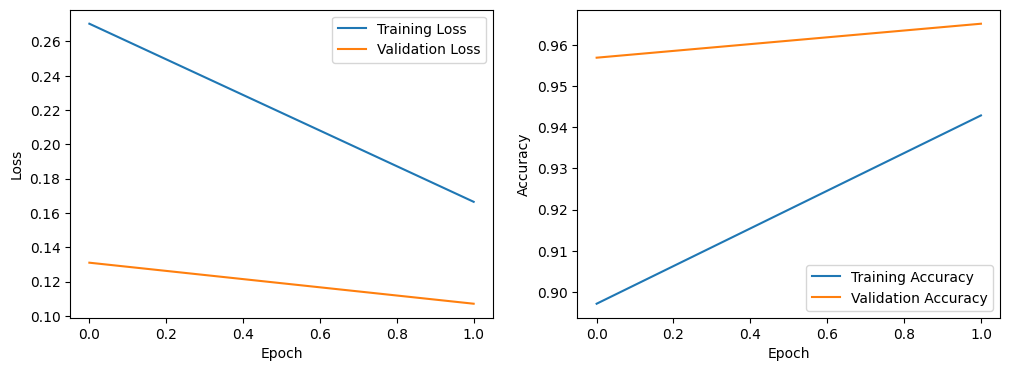

In [15]:
# ploat all
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(all_train_accs, label='Training Accuracy')
plt.plot(all_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        text, target = batch
        inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        pred = model.bert(**inputs).last_hidden_state[:, 0, :].detach().cpu().numpy()
        target = target.argmax(dim=-1).detach().cpu().numpy()
        embeddings.extend(pred)
        labels.extend(target)

embeddings = np.array(embeddings)
labels = np.array(labels)

100%|██████████| 134/134 [07:33<00:00,  3.38s/it]


In [17]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

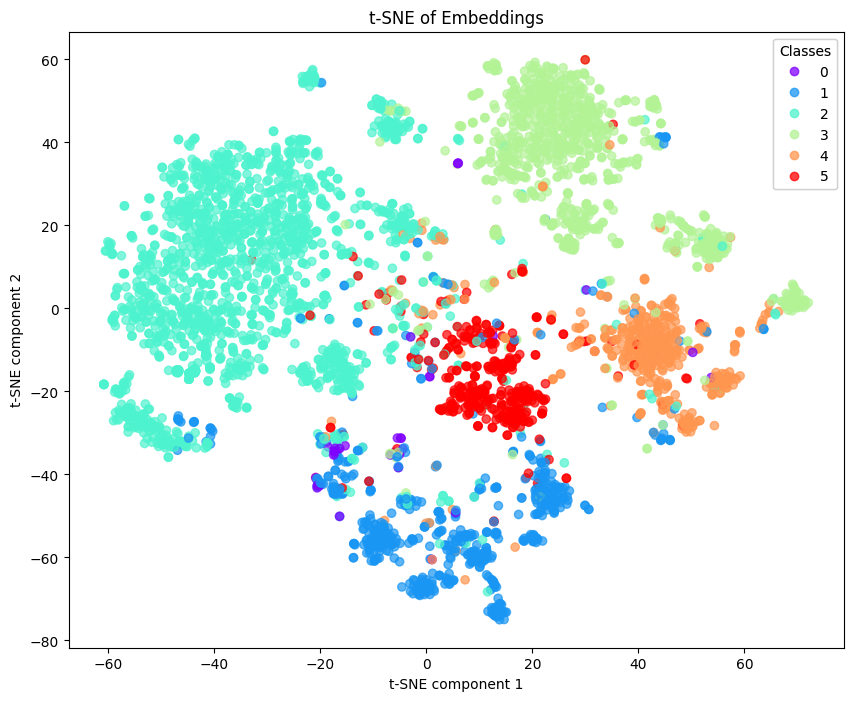

In [18]:
# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='rainbow', alpha=0.7)

# Add a legend
legend = plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
plt.gca().add_artist(legend)

# Add title and labels
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")

# Show plot
plt.show()